# Manual Network finding

This notebook will work finding the best trade-off for our own implemented neural network, using previous data transformation

**Main goals are**: 
- Compare different implementations of neural network
- Understand how a simple neural network works
- Look at the performance and results of PCA's transformed and manually transformed one
- Expose results that will be compared to ML ones


**First we retreive our data and preprocess it :**

In [1]:
from local_lib.dataset import retreiveDatasetFromCsv
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from local_lib.flatten_transformer import FlattenTransformer
from local_lib.dimension_transformer import DimensionTransformer
import numpy as np
from sklearn.decomposition import PCA

dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

pipeline = Pipeline([
    ('flatten_tr', FlattenTransformer()),
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('dimension_tr', DimensionTransformer())])

**We also prepare a version of input data that include PCA transformation**

In [2]:
# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=0)

In [3]:
print(X_train.shape)
print(X_train_pca.shape)

(3923, 26302)
(3923, 50)


_We may expect longer computation time when using manually transformed data_

**Need to transpose input and output layers because we used transposed version of LogLoss for more explicit visualization**

In [4]:
import numpy as np
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)
X_train = X_train.T
X_test = X_test.T

y_train_pca = y_train_pca.reshape(1, -1)
y_test_pca = y_test_pca.reshape(1, -1)
X_train_pca = X_train_pca.T
X_test_pca = X_test_pca.T

In [5]:
print('-----manually transformed')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print('-----pca transformed')
print(X_train_pca.shape)
print(X_test_pca.shape)
print(y_train_pca.shape)
print(y_test_pca.shape)

-----manually transformed
(26302, 3923)
(26302, 1933)
(1, 3923)
(1, 1933)
-----pca transformed
(50, 3923)
(50, 1933)
(1, 3923)
(1, 1933)


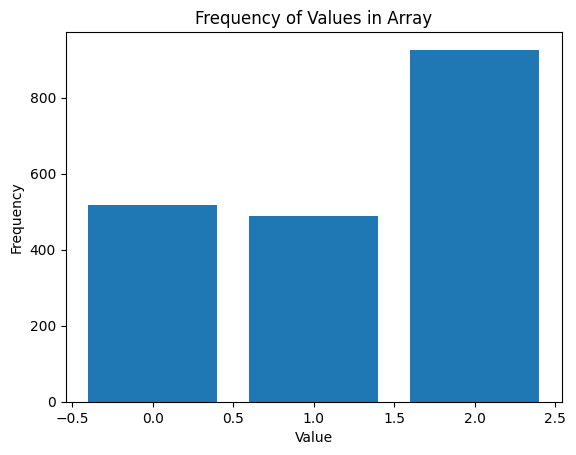

In [6]:
from collections import Counter
import matplotlib.pyplot as plt


counter = Counter(y_test[0])

# Convert Counter to dictionary
grouped = dict(counter)

# Extract keys and values
keys = list(grouped.keys())
values = list(grouped.values())

# Plot the bar chart
plt.bar(keys, values)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Values in Array')
plt.show()


**Very important :** We scale our data to avoid exponential overflow

In [6]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('minmax', MinMaxScaler())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)
X_train_pca = pipeline.fit_transform(X_train_pca)
X_test_pca = pipeline.fit_transform(X_test_pca)

**Very important :** We transform output data to have a shape of (1, 3) so our model can make a prediction on each class and not rescale it between [0,1]

In [7]:
import copy

# Make a copy of the list
y_train_simpler = copy.deepcopy(y_train)
y_train_simpler[y_train_simpler == 2] = 1

y_test_simpler = copy.deepcopy(y_test)
y_test_simpler[y_test_simpler == 2] = 1

print(np.unique(y_train_simpler))
print(np.unique(y_test_simpler))

[0 1]
[0 1]


In [8]:
import numpy as np

# Création de la matrice identité
identity_matrix = np.eye(3)
identity_matrix_simpler = np.eye(2)

# Transformation de t1 en t2
y_train_reshaped = identity_matrix[y_train[0]].T
y_test_reshaped = identity_matrix[y_test[0]].T

y_train_simpler_reshaped = identity_matrix_simpler[y_train_simpler[0]].T
y_test_simpler_reshaped = identity_matrix_simpler[y_test_simpler[0]].T

print(y_train_reshaped.shape)
print(y_test_simpler_reshaped.shape)

(3, 3923)
(2, 1933)


**Instantiate a sample neural network (no output reshape)**

In [8]:
from local_lib.multiclass_neural_network import MultiClassNeuralNetwork
mnn = MultiClassNeuralNetwork(X_train, y_train, dimensions=(8,8,8), n_iter=500, lr=0.05)
hist = mnn.fit(X_train, X_test, y_train,y_test)

{0: 0.16, 1: 0.5, 2: 0.84}
[[0.0, 0.33, 0], [0.33, 0.67, 1], [0.67, 1.0, 2]]


100%|██████████| 500/500 [01:30<00:00,  5.53it/s]


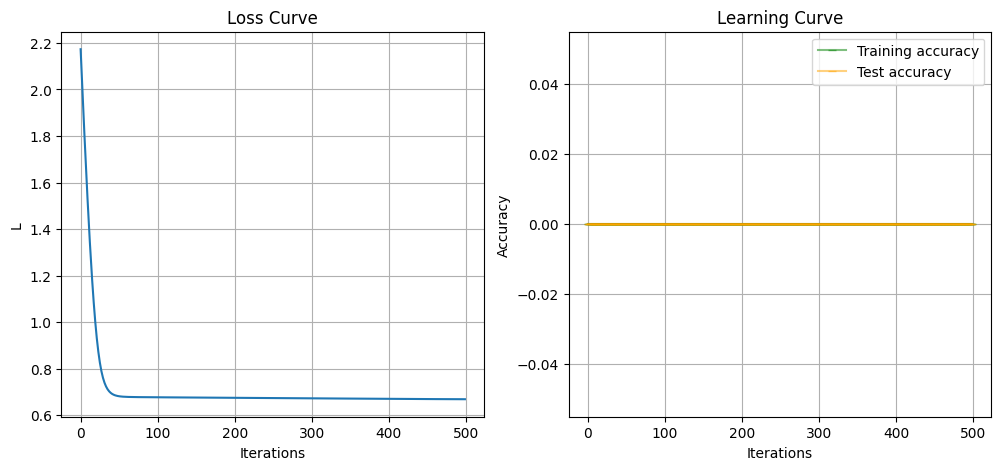

In [9]:
#(8,8,8) [0,1]
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#region Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist[:, 0])
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('L')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), marker='_', label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5), marker='_', label='Test accuracy')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
#endregion

In [10]:
y_pred = mnn.predict(X_test)
print("All differents labels predicted by our mnn :")
np.unique(y_pred)

All differents labels predicted by our mnn :


array([1, 2])

**Huge problems on accuracy due to impact of implementation**<br>
Classes are converted into a range between 0 and 1 but each prediction impact other, even if it's not same classe

In [9]:
from local_lib.neural_network_sequential_batch import NeuralNetworkMultiLayerSequentialStrat
mnn = NeuralNetworkMultiLayerSequentialStrat(X_train, y_train_reshaped, dimensions=(32,32,32), n_iter=500, lr=0.01)
hist = mnn.fit(X_train, X_test, y_train_reshaped,y_test_reshaped)

100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


In [10]:
y_pred = mnn.predict(X_test)
#Number of prediction per cat
np.unique(np.argmax(y_pred, axis=0), return_counts=True)

(array([0, 2], dtype=int64), array([ 296, 1637], dtype=int64))

In [76]:
y_test_reshaped.shape

(3, 1933)

Least accuracy :0.5338851526125195
Least recall :0.5338851526125195
Least precision :0.6609723697437776


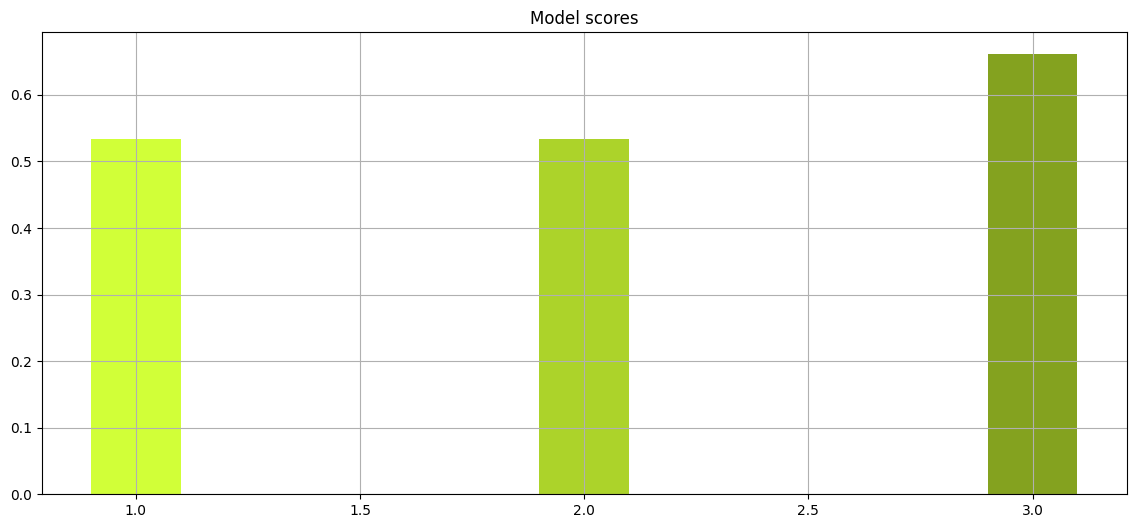

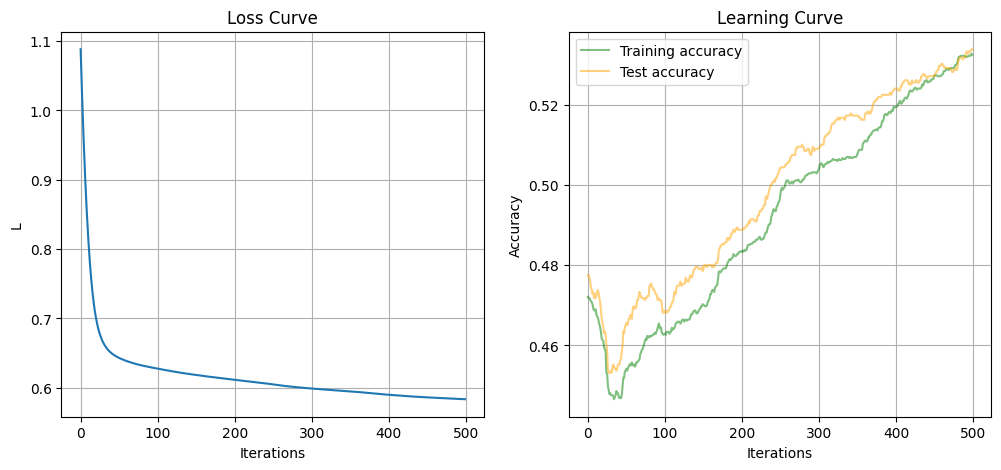

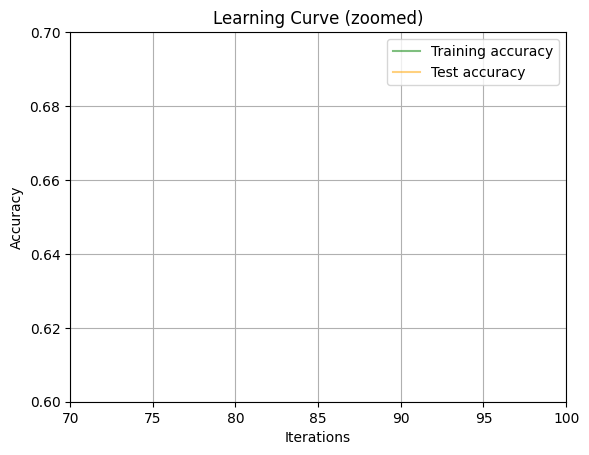

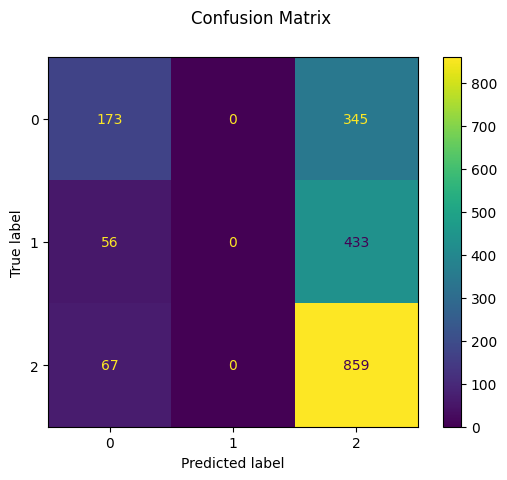

In [11]:
from local_lib.plotting import plotHist
plotHist(hist, y_test_reshaped,y_pred, zoomx=(70,100), zoomy=(0.6,0.7))

**Corrected prediction format, still, computation time is really high and results are terrible**<br>
Switching to PCA processed data

In [26]:
from local_lib.neural_network_sequential_batch import NeuralNetworkMultiLayerSequentialStrat
mnn = NeuralNetworkMultiLayerSequentialStrat(X_train_pca, y_train_reshaped, dimensions=(16,16,16), n_iter=6000, lr=0.05)
hist = mnn.fit(X_train_pca, X_test_pca, y_train_reshaped,y_test_reshaped)

100%|██████████| 6000/6000 [01:08<00:00, 87.97it/s]


In [27]:
y_pred = mnn.predict(X_test_pca)
#Number of prediction per cat
np.unique(np.argmax(y_pred, axis=0), return_counts=True)

(array([0, 1, 2], dtype=int64), array([ 505,  316, 1112], dtype=int64))

Least accuracy :0.743921365752716
Least recall :0.743921365752716
Least precision :0.7309467576683233


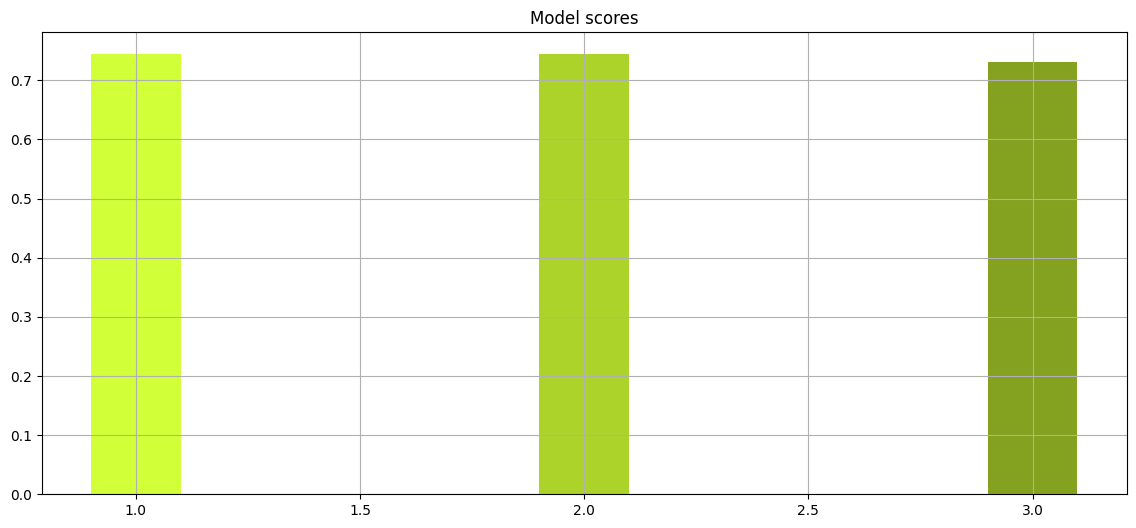

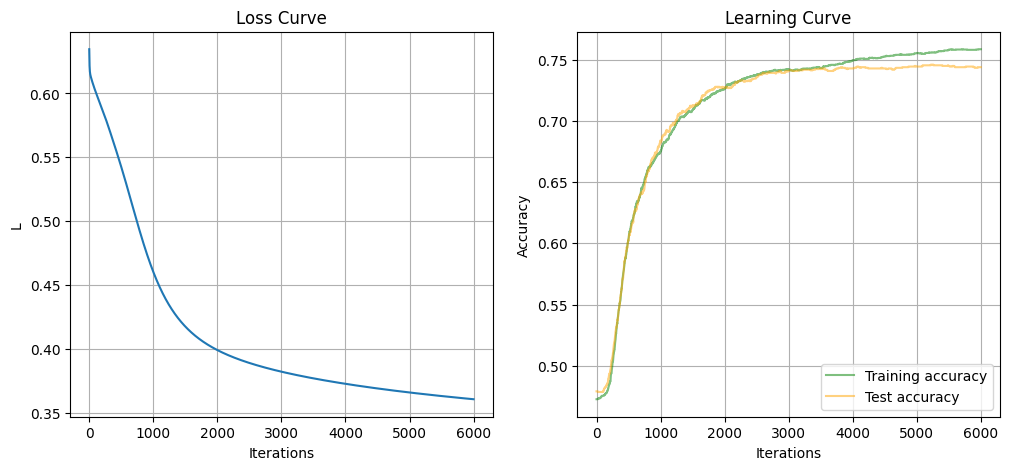

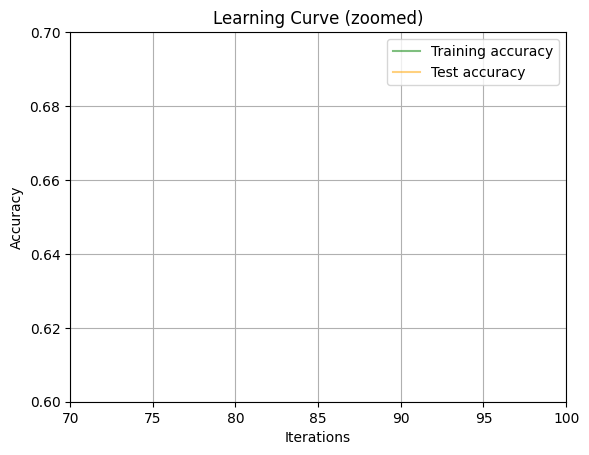

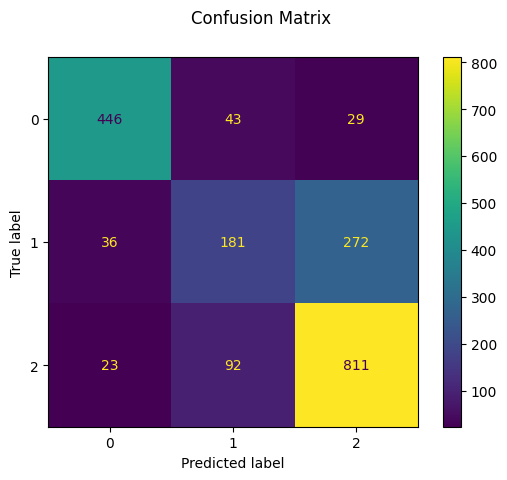

In [28]:
from local_lib.plotting import plotHist
plotHist(hist, y_test_reshaped,y_pred, zoomx=(70,100), zoomy=(0.6,0.7))

**Computation time is better** <br>
Also, PCA seems to add a good first **abstraction that prevent overfit** <br>
_Now we will start to work on generalisation by implementing batching_

**Sequential Batching**

In [34]:
# from local_lib.neural_network_sequential_batch import NeuralNetworkMultiLayerSequentialStrat
mnn = NeuralNetworkMultiLayerSequentialStrat(X_train_pca, y_train_reshaped, dimensions=(16,16,16), n_iter=6000, lr=0.05, strategy="sub", sub_parts=8)
hist = mnn.fit(X_train_pca, X_test_pca, y_train_reshaped,y_test_reshaped)

(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 350.85it/s]


(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 344.52it/s]


(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 359.51it/s]


(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 373.09it/s]


(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 356.18it/s]


(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 358.81it/s]


(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 326.92it/s]


(50, 490)
(50, 241)


100%|██████████| 750/750 [00:02<00:00, 337.02it/s]


In [35]:
y_pred = mnn.predict(X_test_pca)
#Number of prediction per cat
np.unique(np.argmax(y_pred, axis=0), return_counts=True)

(array([0, 1, 2], dtype=int64), array([ 572,  290, 1071], dtype=int64))

Least accuracy :0.7444386963269529
Least recall :0.7444386963269529
Least precision :0.7288469221741972


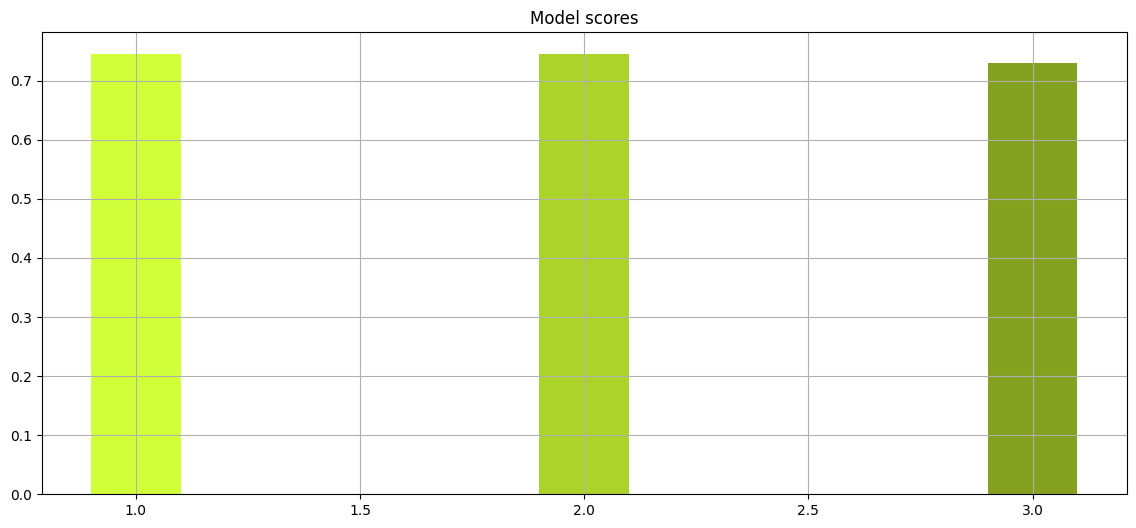

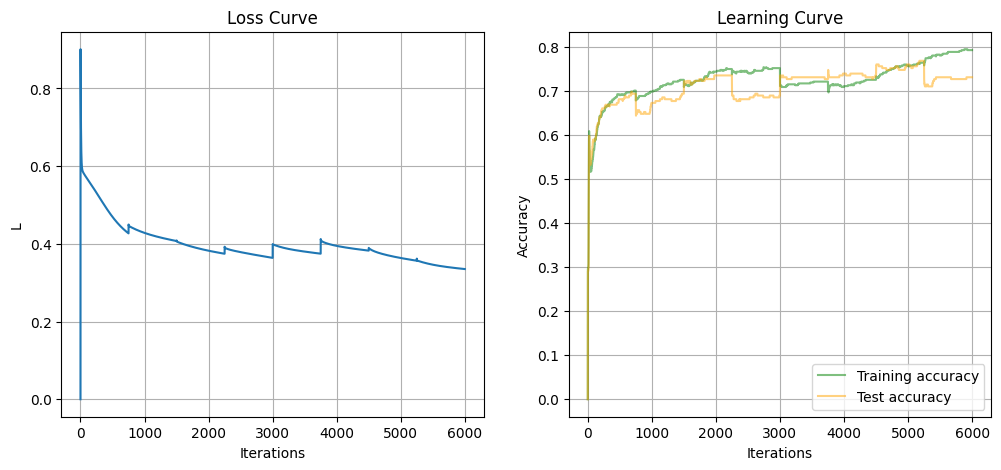

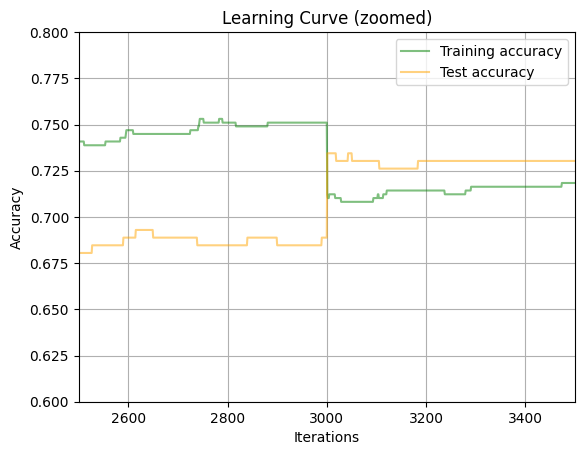

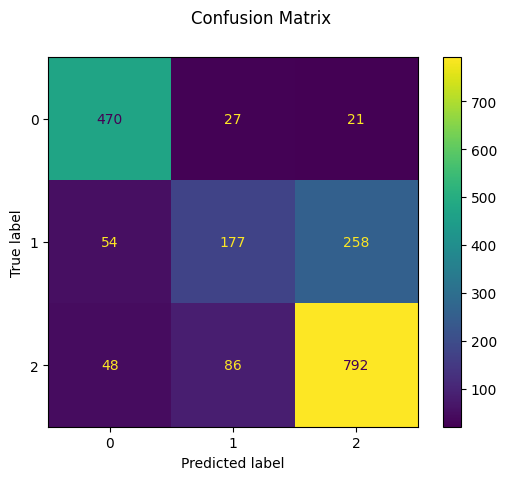

In [38]:
from local_lib.plotting import plotHist
plotHist(hist, y_test_reshaped,y_pred, zoomx=(2500,3500), zoomy=(0.6,0.8))

**May not be the most optimized learning method due to individual overfit on each batch**<br>
Now we will try to implement concurrent batching to avoid overfitting

**Concurrent batching**

In [43]:
from local_lib.neural_network_classic_batch import NeuralNetworkMultiLayerClassicStrat
mnn = NeuralNetworkMultiLayerClassicStrat(X_train_pca, y_train_reshaped, dimensions=(64,64,64), n_iter=6000, lr=0.05, strategy="sub", sub_parts=5)
hist = mnn.fit(X_train_pca, X_test_pca, y_train_reshaped,y_test_reshaped)

100%|██████████| 1199/1199 [01:09<00:00, 17.22it/s]


In [44]:
y_pred = mnn.predict(X_test_pca)
#Number of prediction per cat
np.unique(np.argmax(y_pred, axis=0), return_counts=True)

(array([0, 1, 2], dtype=int64), array([672, 300, 961], dtype=int64))

Least accuracy :0.7284014485256078
Least recall :0.7284014485256078
Least precision :0.7173919612606788


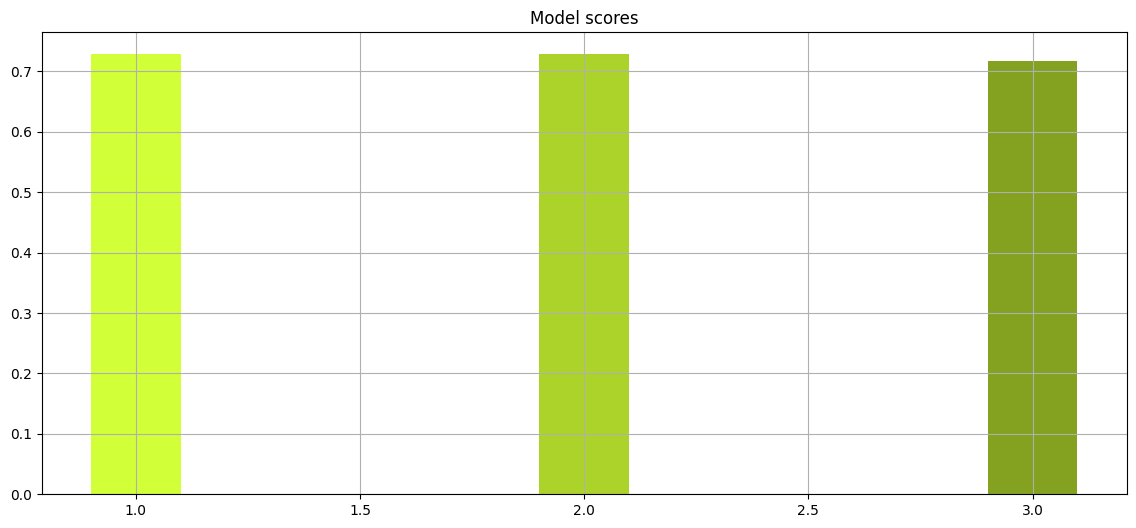

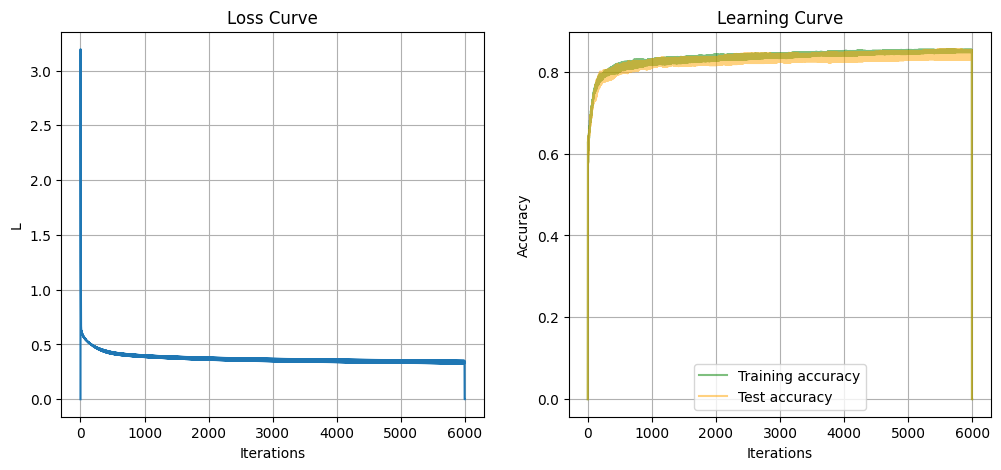

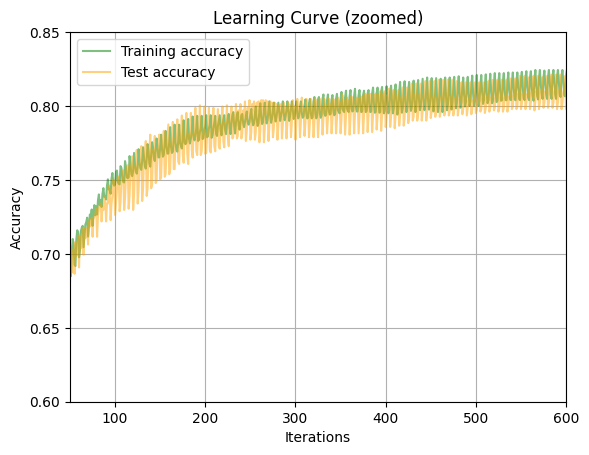

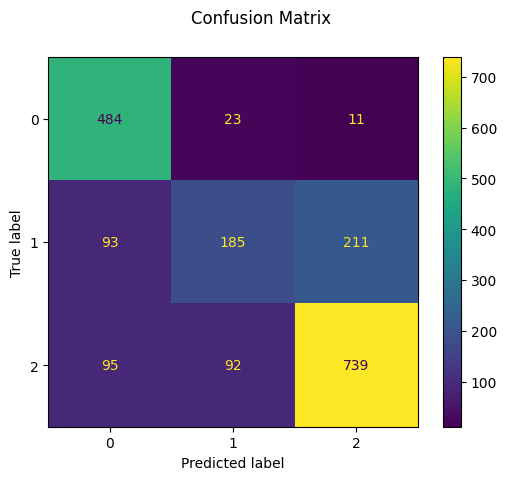

In [48]:
from local_lib.plotting import plotHist
plotHist(hist, y_test_reshaped,y_pred, zoomx=(50,600), zoomy=(0.6,0.85))

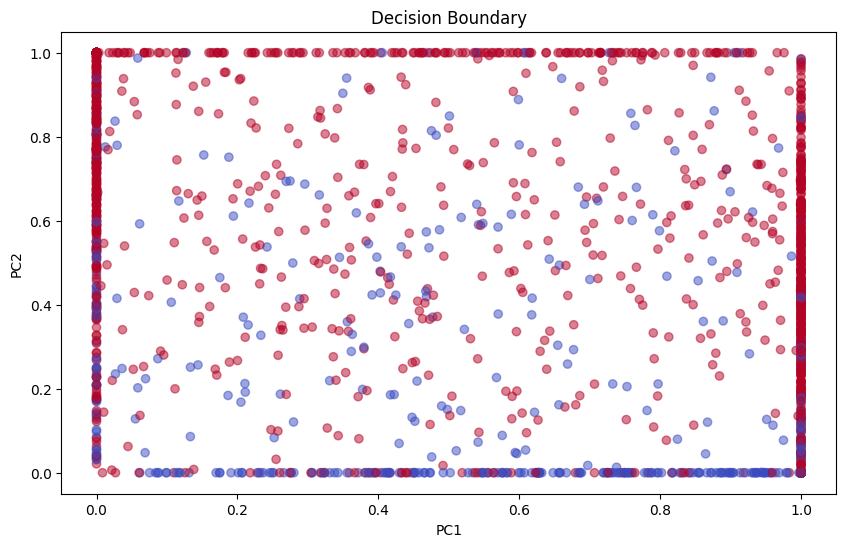

In [49]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

pc_1 = X_test_pca[0, :]
pc_2 = X_test_pca[1, :]

plt.figure(figsize=(10, 6))

xx, yy = np.meshgrid(np.linspace(pc_1.min() - 1, pc_1.max() + 1, 100),
                     np.linspace(pc_2.min() - 1, pc_2.max() + 1, 100))

# plt.contourf(xx, yy, preds, levels=[preds.min(), 0, preds.max()], alpha=0.3, colors=['#FF0000', '#0000FF'])
plt.scatter(pc_1, pc_2, c=y_test_simpler[0], cmap=plt.cm.coolwarm, alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Boundary')
plt.show()
